In [86]:
import pandas as pd
import geopandas as gpd
from sklearn.metrics import precision_score, recall_score,mean_squared_error,r2_score,confusion_matrix
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
run = 8
description = "single seg"
agg = "segments"

In [117]:
#pred = pd.read_csv(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/classification_results.csv")

In [89]:
#pred.groupby('type_pred').size()

In [118]:
gt = gpd.read_file("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/Berlin/Radverkehr_priorisierungskonzept/priorisierungskonzept_validation.gpkg", 
                   dtype={"id": int})
gt = gt[["id", "gid", "ELEM_NR", "checked", "type_ground_truth", "quality_ground_truth"]]

In [122]:
pred = gpd.read_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/berlin_{agg}_pred_cycleways.shp")
columns = ["ID", "TYPE_PRED", "WAY_LENGTH",  "AVG_QUALIT", "AVG_IMG_CO", "SUM_IMG_CO"] #"AVG_CLASS_"
if agg == "segments":
    columns += ["GROUP_NUM"]
pred = pred[columns]
pred.rename(columns={"ID":"id", "TYPE_PRED": "type_pred", "AVG_QUALIT": "avg_quality_pred"}, inplace=True) #"AVG_CLASS_": "avg_class_prob",
pred["uid"] = pred.id.astype(str) +"_" + pred.GROUP_NUM.astype(str)

In [123]:
df = gt.set_index("id").join(pred.set_index("id"))
df = df[df.type_pred.notna()]
df = df[df.type_ground_truth.notna()]
acc_type = (df.type_pred == df.type_ground_truth).sum() / len(df)
acc_type

0.9041095890410958

In [124]:
df[df.type_pred == df.type_ground_truth].WAY_LENGTH.sum() / df.WAY_LENGTH.sum()

0.9189365613126453

In [125]:
# all asphalt benchmark
(df.type_ground_truth == "asphalt").sum() / len(df)

0.7514677103718199

In [126]:
# all asphalt benchmark
df[df.type_ground_truth == "asphalt"].WAY_LENGTH.sum() / df.WAY_LENGTH.sum()

0.7692938388428172

#### Confusion matrix surface types

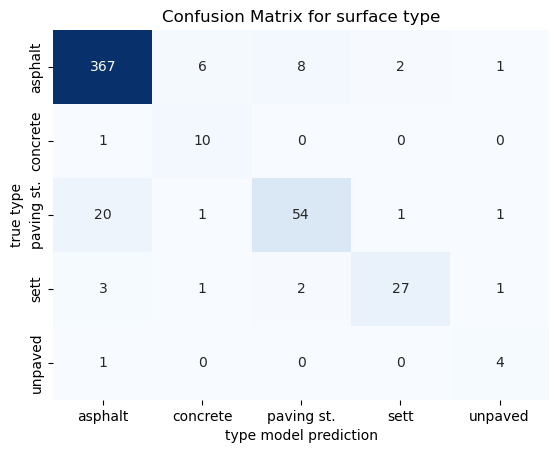

In [127]:
cm = confusion_matrix(df.type_ground_truth, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_run10.png", transparent=True, bbox_inches='tight')
plt.show()

In [128]:
# mismatched streets
m = df[df.type_pred != df.type_ground_truth]
# get geometries
pred = gpd.read_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/berlin_{agg}_pred_cycleways.shp")
pred["uid"] = pred.ID.astype(str) +"_" + pred.GROUP_NUM.astype(str)
misclassified = pred[pred["uid"].isin(m.uid)]

In [129]:
misclassified.to_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/misclassified_{agg}.gpkg", driver="GPKG")

In [130]:
pred[~pred.uid.isin(misclassified.uid)].CONF_SCORE.describe()

count    769.000000
mean       0.871287
std        0.141218
min        0.326702
25%        0.808450
50%        0.921383
75%        0.977517
max        1.000000
Name: CONF_SCORE, dtype: float64

In [131]:
misclassified.CONF_SCORE.describe()

count    49.000000
mean      0.668293
std       0.237584
min       0.259259
25%       0.468783
50%       0.675692
75%       0.888889
max       1.000000
Name: CONF_SCORE, dtype: float64

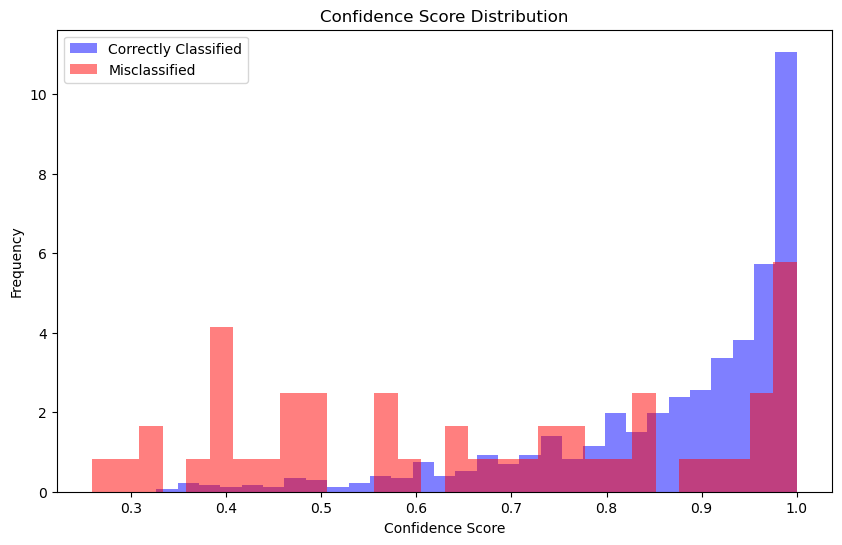

In [132]:
# Plot overlapping histograms
plt.figure(figsize=(10, 6))

# Histogram for correctly classified predictions
plt.hist(pred[~pred.ID.isin(misclassified.ID)]['CONF_SCORE'], bins=30, color='blue', alpha=0.5, label='Correctly Classified', density=True)

# Histogram for misclassified predictions
plt.hist(misclassified['CONF_SCORE'], bins=30, color='red', alpha=0.5, label='Misclassified', density=True)

# Add titles and labels
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

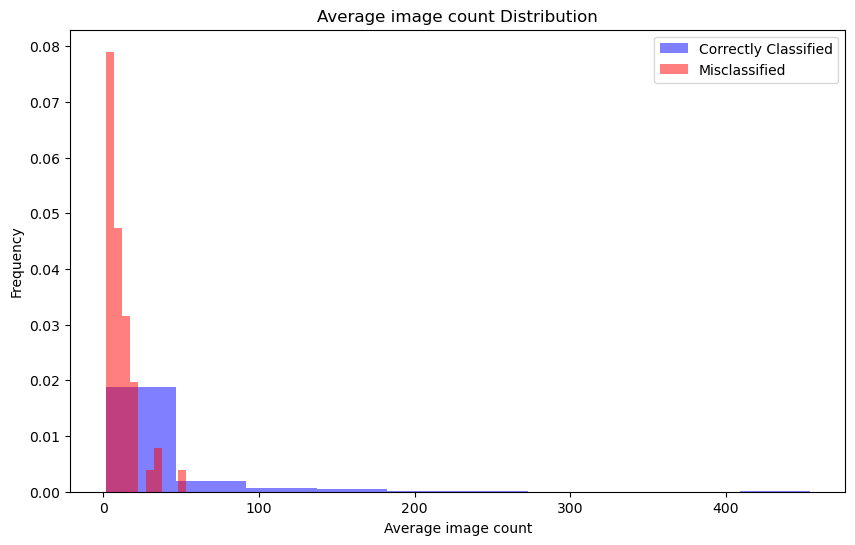

In [140]:
# Plot overlapping histograms
plt.figure(figsize=(10, 6))

# Histogram for correctly classified predictions
plt.hist(pred[~pred.ID.isin(misclassified.ID)]['AVG_IMG_CO'], bins=10, color='blue', alpha=0.5, label='Correctly Classified', density=True)

# Histogram for misclassified predictions
plt.hist(misclassified['AVG_IMG_CO'], bins=10, color='red', alpha=0.5, label='Misclassified', density=True)

# Add titles and labels
plt.title('Average image count Distribution')
plt.xlabel('Average image count')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [141]:
pred[~pred.ID.isin(misclassified.ID)].AVG_IMG_CO.describe()

count    769.000000
mean      29.024460
std       43.569200
min        1.333333
25%        7.000000
50%       15.375000
75%       31.500000
max      454.000000
Name: AVG_IMG_CO, dtype: float64

In [136]:
misclassified.AVG_IMG_CO.describe()

count    49.000000
mean     11.234257
std      10.002905
min       1.333333
25%       4.333333
50%       7.000000
75%      15.333333
max      53.000000
Name: AVG_IMG_CO, dtype: float64

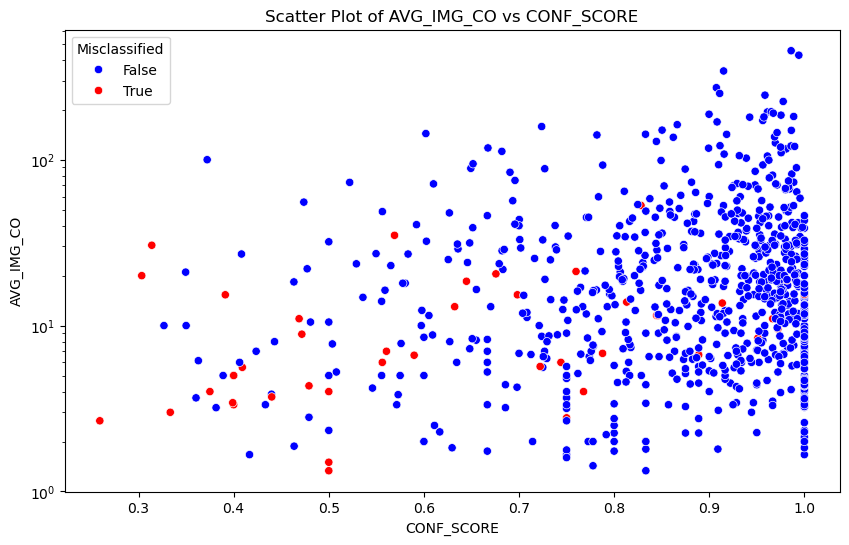

In [144]:
# Create a new column to indicate misclassification
pred['is_misclassified'] = pred.ID.isin(misclassified.ID)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pred, y='AVG_IMG_CO', x='CONF_SCORE', hue='is_misclassified', palette={True: 'red', False: 'blue'})
plt.title('Scatter Plot of AVG_IMG_CO vs CONF_SCORE')
plt.ylabel('AVG_IMG_CO')
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('CONF_SCORE')
plt.legend(title='Misclassified')
plt.show()

In [145]:
import numpy as np
np.corrcoef(pred.AVG_IMG_CO, pred.CONF_SCORE)

array([[1.        , 0.11190513],
       [0.11190513, 1.        ]])

apparently, number of images and confidence score are two predictors if an image is misclassified, however, they are not correlated.

### Quality

In [105]:
df["quality_ground_truth_float"] = df.quality_ground_truth.map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [106]:
def quality_to_class(quality_float):
    if quality_float < 1.5:
        return "excellent"
    elif quality_float < 2.5:
        return "good"
    elif quality_float < 3.5:
        return "intermediate"
    elif quality_float < 4.5:
        return "bad"
    elif quality_float < 5.5:
        return "very_bad"
    else:
        return None
    
df["quality_pred"] = df.avg_quality_pred.apply(quality_to_class)

In [107]:
df.loc[df.avg_quality_pred > 6, "avg_quality_pred"] = None

In [108]:
df["deviation"] = df.quality_ground_truth_float - df.avg_quality_pred
df.deviation.describe()

count    508.000000
mean      -0.003272
std        0.608509
min       -1.669580
25%       -0.441402
50%        0.049405
75%        0.333101
max        1.853381
Name: deviation, dtype: float64

In [109]:
df_quality = df[df.quality_ground_truth_float.notna() & df.avg_quality_pred.notna()] 
mse = mean_squared_error(df_quality.quality_ground_truth_float, df_quality.avg_quality_pred)
mse

0.36956520120966807

In [110]:
df.deviation.describe()

count    508.000000
mean      -0.003272
std        0.608509
min       -1.669580
25%       -0.441402
50%        0.049405
75%        0.333101
max        1.853381
Name: deviation, dtype: float64

<Axes: >

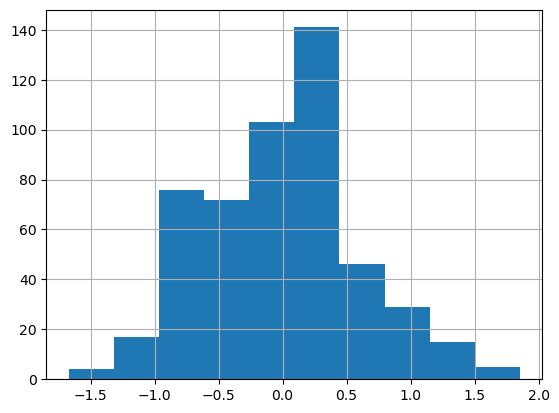

In [111]:
df.deviation.hist()

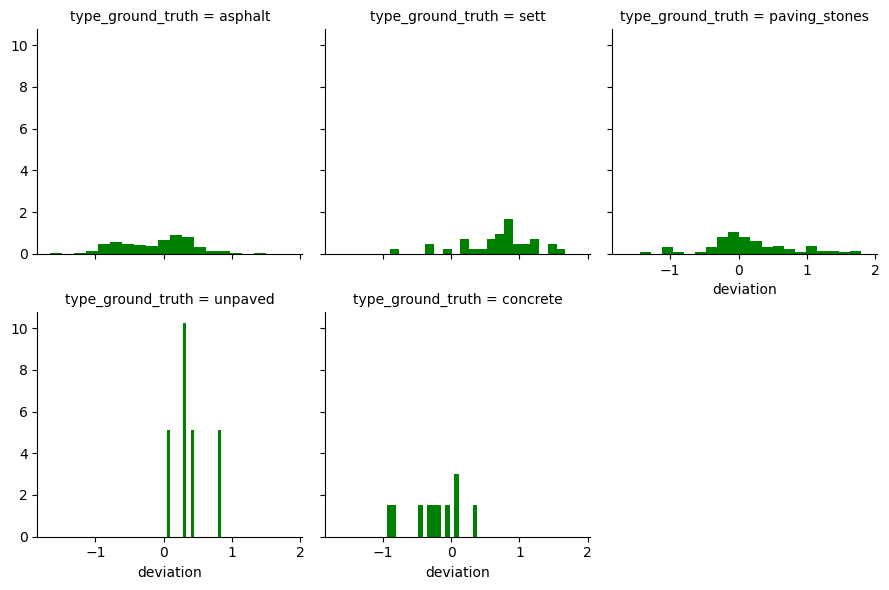

In [112]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df, col="type_ground_truth", col_wrap=3)

# Map histogram for a deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

# positive deviation means that the quality is overestimated

In [113]:
results_df = pd.DataFrame({
    'run':run,
    'description': description,
    'type_accuracy': [round(acc_type, 3)],
    'quality_mean_squared_error': [round(mse, 3)]
})

# Append results to CSV
csv_file_path = '/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/aggregation_alg_results.csv'
results_df.to_csv(csv_file_path, mode='a', header=not pd.io.common.file_exists(csv_file_path), index=False)


In [115]:
df.columns

Index(['gid', 'ELEM_NR', 'checked', 'type_ground_truth',
       'quality_ground_truth', 'type_pred', 'WAY_LENGTH', 'avg_quality_pred',
       'GROUP_NUM', 'uid', 'quality_ground_truth_float', 'quality_pred',
       'deviation'],
      dtype='object')